In [1]:
import os
import sys
from pathlib import Path

import anndata as ad
import cv2 as cv
import h5py
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import scanpy as sc
import seaborn as sns
from joblib import Parallel, delayed
from matplotlib.pyplot import rc_context
from skimage import exposure, io
from skimage.util import img_as_ubyte
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tqdm.notebook import tqdm, trange
from matplotlib.patches import Patch

sc.settings.verbosity = 3

In [2]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"

In [3]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import scanorama


In [4]:
experiment = "Lung"
cores = ['B5', 'C6', 'D4', 'E4', 'E6', 'F4']
datasets = [f'{core}_{i}' for core in cores for i in range(1,5)] + ['F7_3', 'F7_4']


# Load data

In [5]:
import palettable
heatmap_cmp = palettable.cmocean.diverging.Balance_20.mpl_colormap


In [6]:
def read_props(dataset, experiment):
    df_morph = pd.read_csv(data_dir / "props" / f"morphology_IMC_{experiment}_{dataset}.csv")
    df_intensity_IMC = pd.read_csv(data_dir / "props" / f"intensity_IMC_{experiment}_{dataset}.csv")
    df_intensity_TS = pd.read_csv(data_dir / "props" / f"intensity_TS_{experiment}_{dataset}_auto.csv")

    return df_morph, df_intensity_IMC, df_intensity_TS

In [7]:
%%capture 

adatas = []
df_sums = []
for dataset in datasets:
    try:
        df_morph, df_intensity_IMC, df_intensity_TS = read_props(dataset, experiment)
        print(f'Sucessfully read dataset {dataset}') 
    except:
        print(f'{dataset} cannot be read') 
        continue
    try:
        df_intensity_TS.drop(['Rest', 'Total'], axis=1, inplace=True)
    except:
        pass
    df_intensity_TS.iloc[:, 1:] = df_intensity_TS.iloc[:, 1:].multiply(
        df_morph["area"], axis=0
    )
    data_all = df_intensity_TS.iloc[:, 1:].values
    # data_all_norm = (data_all+0.1)/(np.percentile(data_all,50,axis=1,keepdims=True)+0.1)
    # data_all_norm = MinMaxScaler().fit_transform(data_all)
    # df_intensity_TS.iloc[:, 1:] = data_all_norm
    
    # Merge TS and IMC data
    df = df_intensity_TS
    df.set_index("Id", inplace=True)
    df_sums.append(df.sum(axis=0))
    
    # Put to adata format
    adata = sc.AnnData(df.values)
    adata.var_names = df.columns.tolist()
    adata.obs["Cell"] = df.index.tolist()
    adata.obs["Dataset"] = dataset
    adata.obs["Core"] = dataset.split("_")[0]
    adata.obsm["spatial"] = df_morph[["centroid-0", "centroid-1"]].to_numpy()
    sc.pp.normalize_total(adata, target_sum=1e5)
    sc.pp.log1p(adata)
    sc.pp.scale(adata)
    # data_all_norm = MinMaxScaler().fit_transform(adata.X)
    # adata.X = data_all_norm
    adatas.append(adata)
adata = ad.concat(adatas, join="inner")

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished ({time_passed})
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished ({time_passed})
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished ({time_passed})
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished ({time_passed})
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normali

C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\scanpy\plotting\_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


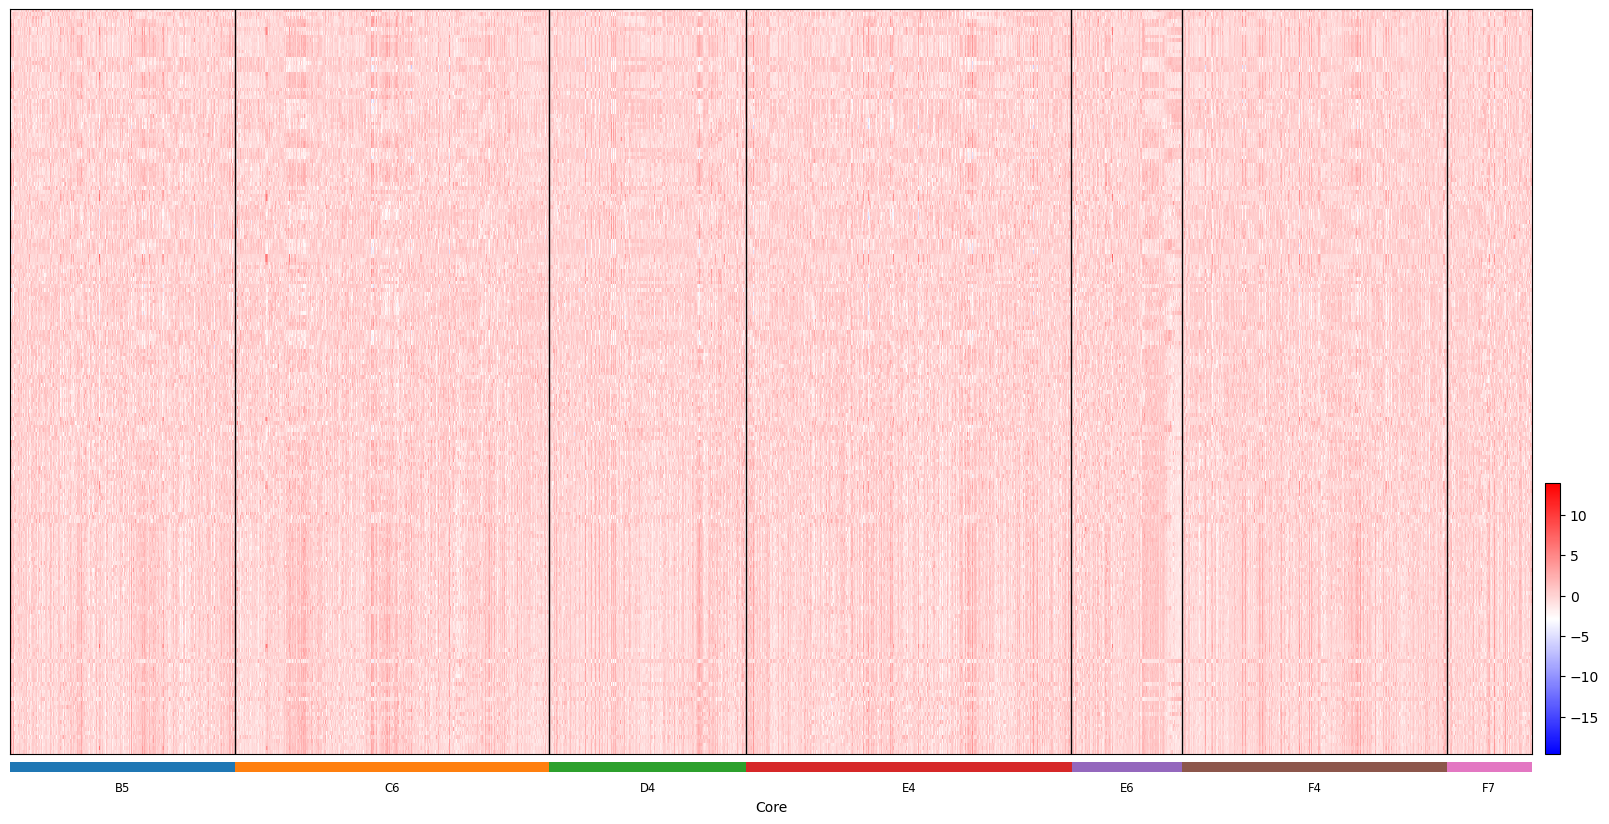

In [8]:
sc.pl.heatmap(adata, adata.var_names, groupby='Core', swap_axes=True, cmap='bwr', figsize=(20,10))

In [9]:
# Read Protein clustering info
path = data_dir / "adata" / f"{experiment}.h5ad"
adata_IMC_cluster = ad.read_h5ad(path)


C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [10]:
adata = adata[~adata.obs.Dataset.isin(['F7_1', 'F7_2'])]
adata_IMC = adata_IMC_cluster[~adata_IMC_cluster.obs.Dataset.isin(['F7_1', 'F7_2'])]

In [11]:
df_sum = pd.concat(df_sums, axis=1).mean(axis=1)
mz_qc = df_sum[(df_sum > 31000)].index.tolist()
# mz_qc = df_sum[(df_sum > 227)].index.tolist()

In [12]:
len(mz_qc)

163

In [13]:
adata = adata[:, mz_qc]

## Get literature lut

In [14]:
SIMS_masses = adata.var_names

In [15]:
# Read litterature lut
file_path = data_dir / "metadata" / 'Putative_annotation_09012022.xlsx'
df = pd.read_excel(file_path)
lum = df['m/z'].to_numpy()

# get matched table by looking at difference with error
error = 0.4
matched_dfs = []
for mz in SIMS_masses.astype(float):
    if mz < 1.1:
        continue
    diff = lum-mz
    matched = df[abs(diff)<error]
    if len(matched) > 0:
        matched.loc[:,'SIMS mz'] = mz
        matched_dfs.append(matched)
    else:
        matched = pd.DataFrame([['', '', '', '', mz]], columns=df.columns.tolist() + ['SIMS mz'])
        matched_dfs.append(matched)
matched = pd.concat(matched_dfs)

C:\Users\thu71\AppData\Local\Temp\ipykernel_27088\1921335408.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched.loc[:,'SIMS mz'] = mz
C:\Users\thu71\AppData\Local\Temp\ipykernel_27088\1921335408.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched.loc[:,'SIMS mz'] = mz
C:\Users\thu71\AppData\Local\Temp\ipykernel_27088\1921335408.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [16]:
# Get all info from litterature excel
SIMS_masses_subset = np.array(matched['SIMS mz'].to_list(), dtype=float).astype(str)
SIMS_masses_subset = pd.Index(SIMS_masses_subset)

matched.loc[matched['Molecules'] != '', 'Molecules'] = ' ' + matched.loc[matched['Molecules'] != '', 'Molecules']
SIMS_name_subset = np.array(matched['Molecules'].to_list()).astype(str)
SIMS_name_subset = pd.Index(SIMS_name_subset)
SIMS_name_subset = SIMS_name_subset

SIMS_nm_subset = SIMS_masses_subset + 'm/z' + SIMS_name_subset 

SIMS_type_subset = np.array(matched['Type'].to_list()).astype(str)
SIMS_type_subset = pd.Index(SIMS_type_subset)

print(f"Number of matched m/z: {len(SIMS_masses_subset)}")

Number of matched m/z: 162


In [17]:
adata_all = adata.copy()
adata = adata[:, SIMS_masses_subset]
adata.var_names = SIMS_nm_subset

C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [18]:
SIMS_nm_subset

Index(['12.0m/z', '13.0m/z', '14.0m/z', '16.0m/z', '17.0m/z', '22.6m/z',
       '24.0m/z', '25.0m/z L-Frag', '26.0m/z L-Frag', '27.0m/z',
       ...
       '193.9m/z', '195.9m/z', '200.9m/z', '204.9m/z Hydroquinone',
       '208.9m/z L-Frag', '210.0m/z', '216.9m/z', '228.9m/z', '233.9m/z',
       '253.3m/z FA(16:1)'],
      dtype='object', length=162)

# Comparison Cell type

In [19]:
# adata.obs["Type"] = adata_IMC.obs["Type"]
# adata.uns["Type_colors"] = adata_IMC.uns["Type_colors"]
adata.obs["Region"] = adata_IMC.obs["Region"]
adata.uns["Region_colors"] = adata_IMC.uns["Region_colors"]
adata.obsm["spatial"] = adata_IMC.obsm["spatial"]

In [20]:
type_dict = {'CD68+CD4+': 'CD68+', 
             'Stroma CD31+': 'Stroma' , 
             'Tumor': 'Tumor', 
             'CD3+': 'T cells', 
             'Other': 'Other', 
             'CD68+': 'CD68+', 
             'Stroma': 'Stroma', 
             'CD4+': 'T cells', 
             'Vimentin+': 'Stroma', 
             'GranzymeB+': 'T cells',
            }

In [21]:
adata.obs['Type'] = (
    adata_IMC.obs['Type']
    .map(type_dict)
    .astype("category")
)


In [22]:
adata_s = adata[adata.obs["Type"].isin(['CD68+', 'T cells'])]

In [ ]:
adata_s.obs['Type'].value_counts()

T cells    4156
CD68+      2516
Name: Type, dtype: int64

         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:00)
Storing dendrogram info using `.uns['dendrogram_Type']`
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


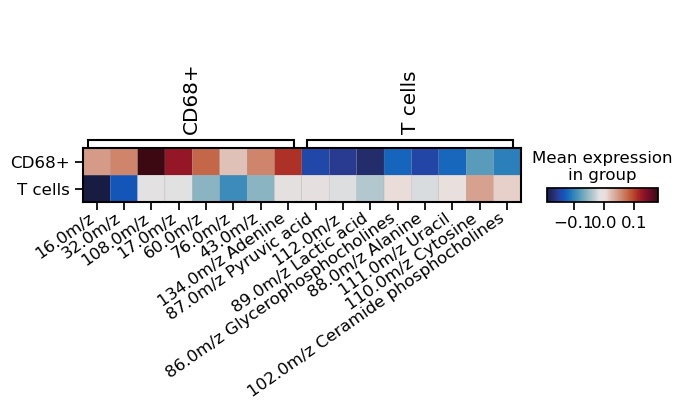

In [66]:
sc.tl.dendrogram(adata_s, groupby='Type')
sc.tl.rank_genes_groups(adata_s, groupby='Type', method='t-test_overestim_var')

with sns.plotting_context('notebook', font_scale=1.2):
    ax = sc.pl.rank_genes_groups_matrixplot(adata_s, n_genes=8, use_raw=False, cmap=heatmap_cmp, show=False)
    xticklabels = ax['mainplot_ax'].get_xticklabels()
    ax['mainplot_ax'].set_xticklabels(xticklabels, rotation = 35, ha="right")
    ax['mainplot_ax'].tick_params(axis='x', pad=0)
    plt.show()

In [67]:
# Extract diff expression dataframe
dedf = sc.get.rank_genes_groups_df(adata_s, group=None)

# Get top diff expression
topk=7
masses_largest = dedf.groupby('group').apply(lambda x: x.nlargest(topk,['scores'])).names.unique()
masses_lowest = dedf.groupby('group').apply(lambda x: x.nsmallest(topk,['scores'])).names.unique()
# masses = np.unique(np.concatenate([masses_largest, masses_lowest]))
masses = masses_largest

In [68]:
var = 'Type'

# Get subset of masses
adata_subset = adata_s[:,masses]

# Get dataframe
df_SIMS = pd.DataFrame(adata_subset.X, columns=adata_subset.var_names)
df_SIMS[var] = adata_subset.obs[var].tolist()
# df_SIMS.drop(['1.0'], axis=1, inplace=True)

# Sort masses by GC eexpression
df_SIMS_var = (df_SIMS
                .melt(id_vars=var, var_name='mz', value_name='Normalized ion count'))
df = df_SIMS_var[df_SIMS_var[var] == 'Tumor'].groupby('mz').mean()
df.sort_values('Normalized ion count', inplace=True)
masses_sorted = df.index.tolist()

C:\Users\thu71\AppData\Local\Temp\ipykernel_35764\558677848.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df_SIMS_var[df_SIMS_var[var] == 'Tumor'].groupby('mz').mean()


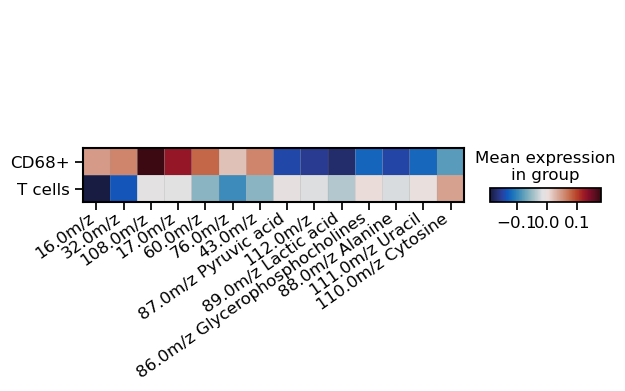

In [69]:
with sns.plotting_context('notebook', font_scale=1.2):
    ax = sc.pl.matrixplot(adata_subset, var_names=masses, groupby='Type',
                    cmap=heatmap_cmp, dendrogram=True, show=False)
    xticklabels = ax['mainplot_ax'].get_xticklabels()
    ax['mainplot_ax'].set_xticklabels(xticklabels, rotation = 35, ha="right")
    ax['mainplot_ax'].tick_params(axis='x', pad=0)
    plt.show()

C:\Users\thu71\AppData\Local\Temp\ipykernel_35764\1831911649.py:9: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_SIMS.iloc[:,:-1] = MinMaxScaler().fit_transform(df_SIMS.iloc[:,:-1].values)


[(0.2, 1.0)]

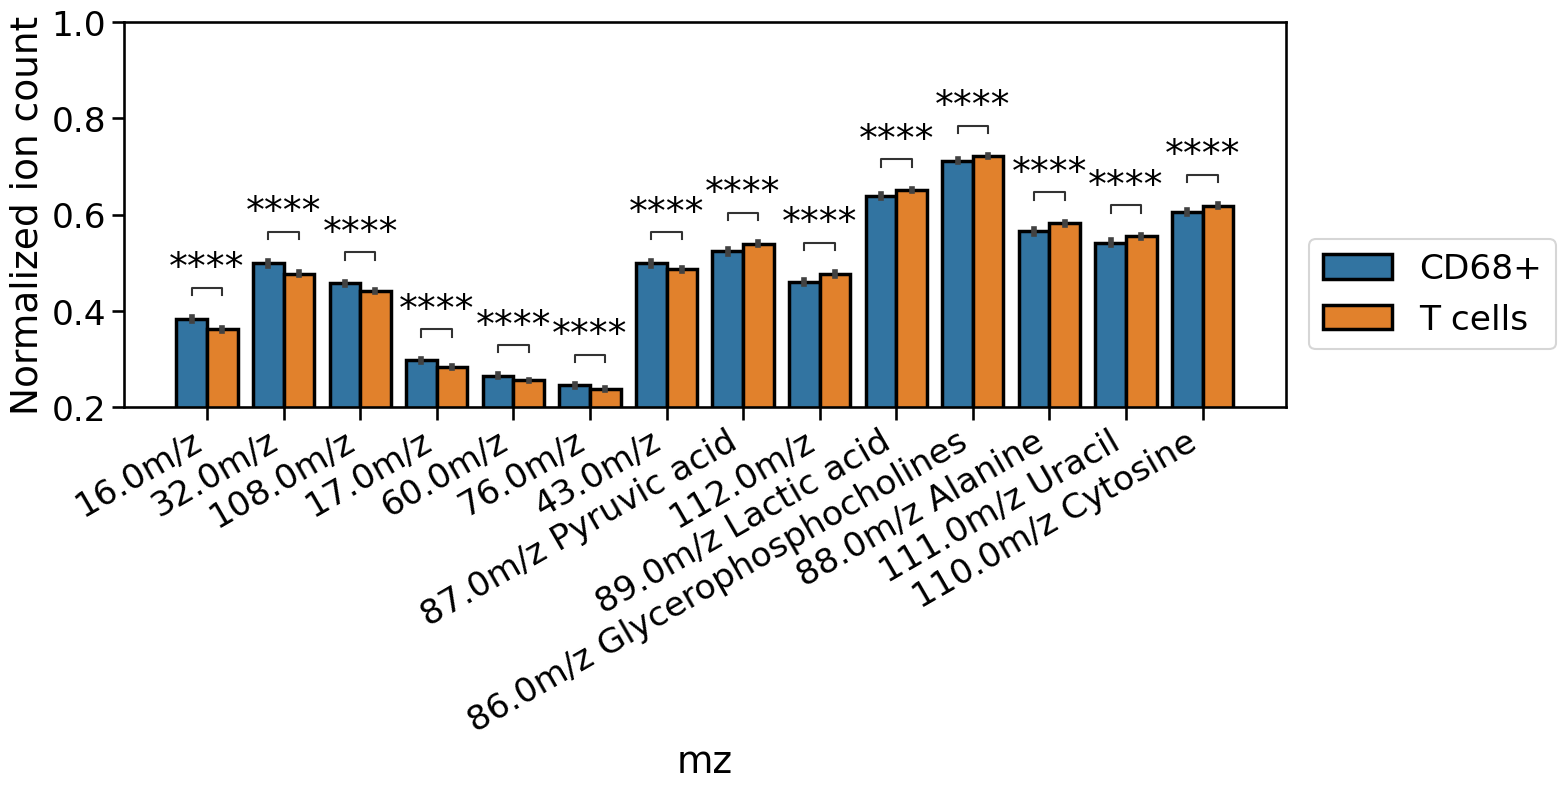

In [70]:
sns.set_context('talk', font_scale=1.5)
from statannotations.Annotator import Annotator

sns.set_context('talk', font_scale=1.5)

# Get dataframe
df_SIMS = pd.DataFrame(adata_subset.X, columns=adata_subset.var_names)
df_SIMS[var] = adata_subset.obs[var].tolist()
df_SIMS.iloc[:,:-1] = MinMaxScaler().fit_transform(df_SIMS.iloc[:,:-1].values)

# Sort masses by GC eexpression
df_SIMS_var = (df_SIMS
                .melt(id_vars=var, var_name='mz', value_name='Normalized ion count'))

# Plot
var = 'Type'
hue_order = ['CD68+', 'T cells']

fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(data=df_SIMS_var, hue=var, x='mz', y='Normalized ion count', linewidth=2.5, edgecolor='k',
            hue_order = hue_order, ax=ax)
plt.xticks(rotation = 30, ha='right')
plt.legend(bbox_to_anchor=(1.02, 0.15), loc='lower left', borderaxespad=0)

pairs = [((e, 'CD68+'),(e, 'T cells')) for e in masses]
annot = Annotator(ax, pairs, data=df_SIMS_var, hue=var, x='mz', y='Normalized ion count', hue_order = hue_order)
annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=0)
annot.apply_test()
ax, test_results = annot.annotate()
ax.set(ylim=(.2, 1.))

In [71]:
glucose_frag = ['71.0m/z', '87.0m/z Pyruvic acid', '99.0m/z L-Frag', '119.0m/z', '141.0m/z L-Frag', '74.0m/z Glycine',  '89.0m/z Lactic acid', '122.0m/z', ]
adata_subset = adata_s[:,glucose_frag]

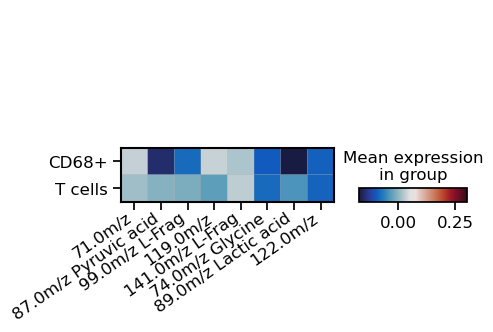

In [72]:
with sns.plotting_context('notebook', font_scale=1.2):
    ax = sc.pl.matrixplot(adata_subset, var_names=glucose_frag, groupby='Type',
                    cmap=heatmap_cmp, dendrogram=True, show=False, vmax=0.3)
    xticklabels = ax['mainplot_ax'].get_xticklabels()
    ax['mainplot_ax'].set_xticklabels(xticklabels, rotation = 35, ha="right")
    ax['mainplot_ax'].tick_params(axis='x', pad=0)
    plt.show()

# Comparison immune cells in tumor vs non tumor

In [28]:
adata_s = adata[adata.obs["Type"] == 'T cells']
adata_s = adata_s[adata_s.obs['Region'] != 'Other']

In [29]:
adata_s.obs['Region'].value_counts()

Stroma    2318
Tumor     1065
Name: Region, dtype: int64

         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:00)
Storing dendrogram info using `.uns['dendrogram_Region']`
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


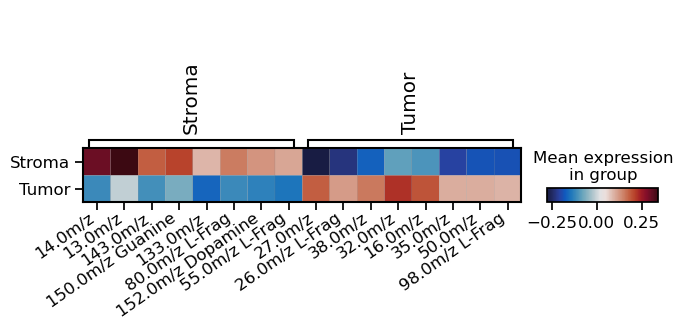

In [74]:
sc.tl.dendrogram(adata_s, groupby='Region')
sc.tl.rank_genes_groups(adata_s, groupby='Region', method='t-test_overestim_var')

with sns.plotting_context('notebook', font_scale=1.2):
    ax = sc.pl.rank_genes_groups_matrixplot(adata_s, n_genes=8, use_raw=False, cmap=heatmap_cmp, show=False)
    xticklabels = ax['mainplot_ax'].get_xticklabels()
    ax['mainplot_ax'].set_xticklabels(xticklabels, rotation = 35, ha="right")
    ax['mainplot_ax'].tick_params(axis='x', pad=0)
    plt.show()

In [75]:
# Extract diff expression dataframe
dedf = sc.get.rank_genes_groups_df(adata_s, group=None)

# Get top diff expression
topk=5
masses_largest = dedf.groupby('group').apply(lambda x: x.nlargest(topk,['scores'])).names.unique()
masses_lowest = dedf.groupby('group').apply(lambda x: x.nsmallest(topk,['scores'])).names.unique()
# masses = np.unique(np.concatenate([masses_largest, masses_lowest]))
masses = masses_largest

In [76]:
var = 'Region'

# Get subset of masses
adata_subset = adata_s[:,masses]

# Get dataframe
df_SIMS = pd.DataFrame(adata_subset.X, columns=adata_subset.var_names)
df_SIMS[var] = adata_subset.obs[var].tolist()
# df_SIMS.drop(['1.0'], axis=1, inplace=True)

# Sort masses by GC eexpression
df_SIMS_var = (df_SIMS
                .melt(id_vars=var, var_name='mz', value_name='Normalized ion count'))
df = df_SIMS_var[df_SIMS_var[var] == 'Tumor'].groupby('mz').mean()
df.sort_values('Normalized ion count', inplace=True)
masses_sorted = df.index.tolist()

C:\Users\thu71\AppData\Local\Temp\ipykernel_35764\2276558160.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df_SIMS_var[df_SIMS_var[var] == 'Tumor'].groupby('mz').mean()


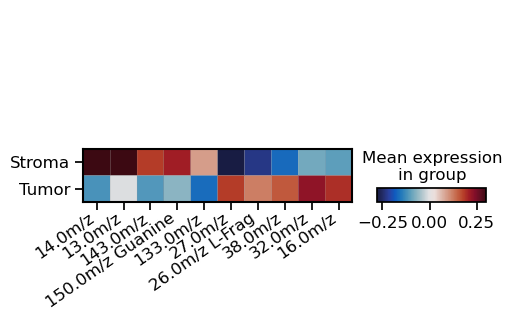

In [77]:
with sns.plotting_context('notebook', font_scale=1.2):
    ax = sc.pl.matrixplot(adata_subset, var_names=masses, groupby='Region',
                    cmap=heatmap_cmp, dendrogram=True, show=False, vmax=0.3)
    xticklabels = ax['mainplot_ax'].get_xticklabels()
    ax['mainplot_ax'].set_xticklabels(xticklabels, rotation = 35, ha="right")
    ax['mainplot_ax'].tick_params(axis='x', pad=0)
    plt.show()

C:\Users\thu71\AppData\Local\Temp\ipykernel_35764\2206271859.py:10: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_SIMS.iloc[:,:-1] = MinMaxScaler().fit_transform(df_SIMS.iloc[:,:-1].values)


[(0.2, 1.0)]

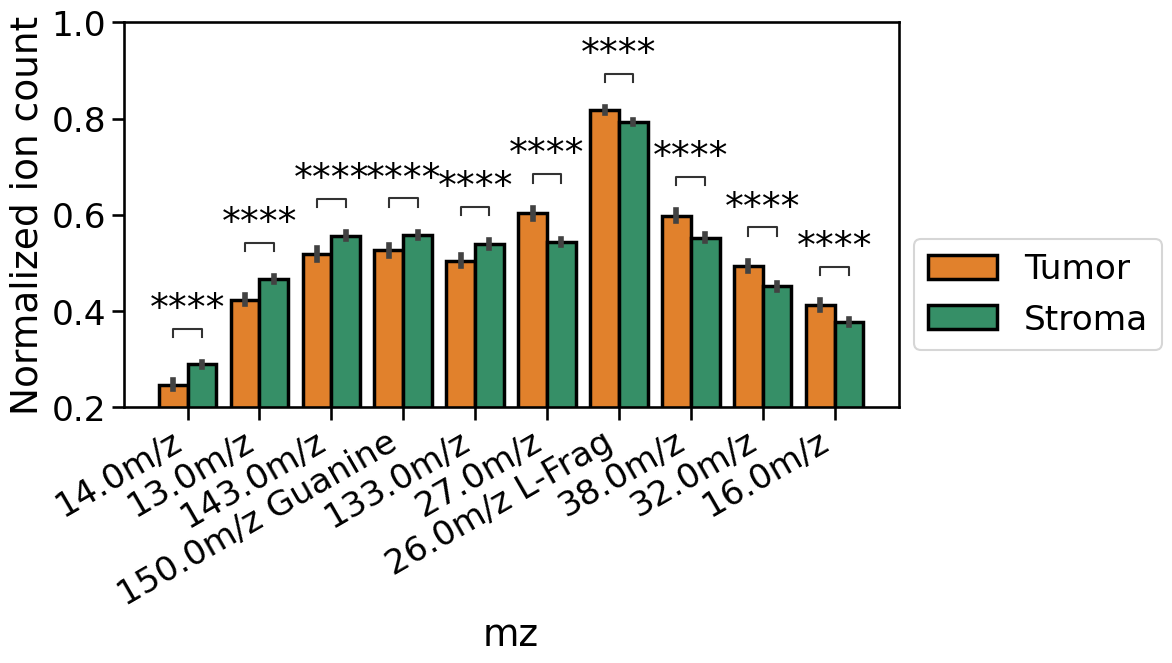

In [78]:
sns.set_context('talk', font_scale=1.5)
from statannotations.Annotator import Annotator

sns.set_context('talk', font_scale=1.5)

# Get dataframe
df_SIMS = pd.DataFrame(adata_subset.X, columns=adata_subset.var_names)
df_SIMS[var] = adata_subset.obs[var].tolist()
df_SIMS = df_SIMS[df_SIMS[var] != 'Other']
df_SIMS.iloc[:,:-1] = MinMaxScaler().fit_transform(df_SIMS.iloc[:,:-1].values)

# Sort masses by GC eexpression
df_SIMS_var = (df_SIMS
                .melt(id_vars=var, var_name='mz', value_name='Normalized ion count'))

# Plot
var = 'Region'
hue_order = ['Tumor', 'Stroma']
palette = adata_subset.uns[f'{var}_colors'][adata_subset.uns[f'dendrogram_{var}']['categories_idx_ordered']]

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(data=df_SIMS_var, hue=var, x='mz', y='Normalized ion count', linewidth=2.5, edgecolor='k',
            hue_order = ['Tumor', 'Stroma'], ax=ax, palette=palette)
plt.xticks(rotation = 30, ha='right')
plt.legend(bbox_to_anchor=(1.02, 0.15), loc='lower left', borderaxespad=0)

pairs = [((e,'Tumor'),(e,'Stroma')) for e in masses]
annot = Annotator(ax, pairs, data=df_SIMS_var, hue=var, x='mz', y='Normalized ion count', hue_order = ['Tumor', 'Stroma'])
annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=0)
annot.apply_test()
ax, test_results = annot.annotate()
ax.set(ylim=(.2, 1.))

In [79]:
glucose_frag = ['71.0m/z', '87.0m/z Pyruvic acid', '99.0m/z L-Frag', '119.0m/z', '141.0m/z L-Frag', '74.0m/z Glycine',  '89.0m/z Lactic acid', '122.0m/z', ]
adata_subset = adata_s[:,glucose_frag]

C:\Users\thu71\AppData\Local\Temp\ipykernel_35764\42099666.py:5: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_SIMS.iloc[:,:-1] = MinMaxScaler().fit_transform(df_SIMS.iloc[:,:-1].values)


[(0.2, 1.0)]

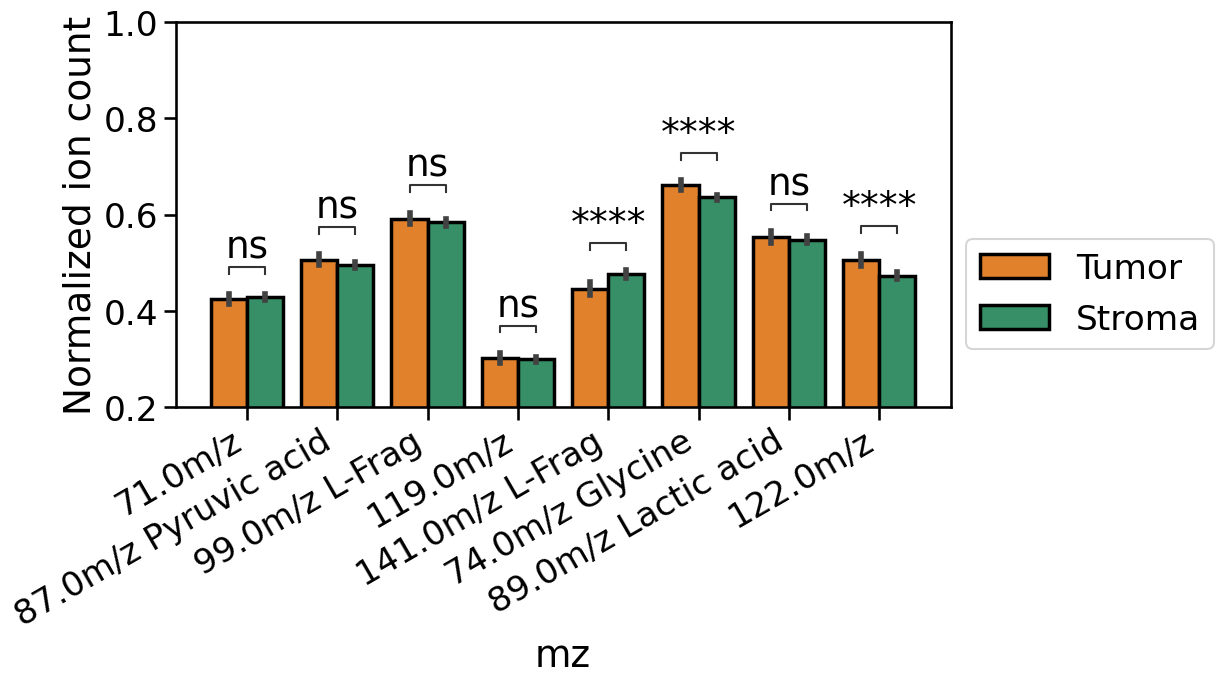

In [80]:
# Get dataframe
df_SIMS = pd.DataFrame(adata_subset.X, columns=adata_subset.var_names)
df_SIMS[var] = adata_subset.obs[var].tolist()
df_SIMS = df_SIMS[df_SIMS[var] != 'Other']
df_SIMS.iloc[:,:-1] = MinMaxScaler().fit_transform(df_SIMS.iloc[:,:-1].values)

# Sort masses by GC eexpression
df_SIMS_var = (df_SIMS
                .melt(id_vars=var, var_name='mz', value_name='Normalized ion count'))

# Plot
var = 'Region'
hue_order = ['Tumor', 'Stroma']
palette = adata_subset.uns[f'{var}_colors'][adata_subset.uns[f'dendrogram_{var}']['categories_idx_ordered']]

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(data=df_SIMS_var, hue=var, x='mz', y='Normalized ion count', linewidth=2.5, edgecolor='k',
            hue_order = ['Tumor', 'Stroma'], ax=ax, palette=palette)
plt.xticks(rotation = 30, ha='right')
plt.legend(bbox_to_anchor=(1.02, 0.15), loc='lower left', borderaxespad=0)

pairs = [((e,'Tumor'),(e,'Stroma')) for e in glucose_frag]
annot = Annotator(ax, pairs, data=df_SIMS_var, hue=var, x='mz', y='Normalized ion count', hue_order = ['Tumor', 'Stroma'])
annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=0)
annot.apply_test()
ax, test_results = annot.annotate()
ax.set(ylim=(.2, 1.))

# Comparison per patient

In [81]:
adata_subset = adata[adata.obs['Region'] == 'Tumor']

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_Core']`
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.l

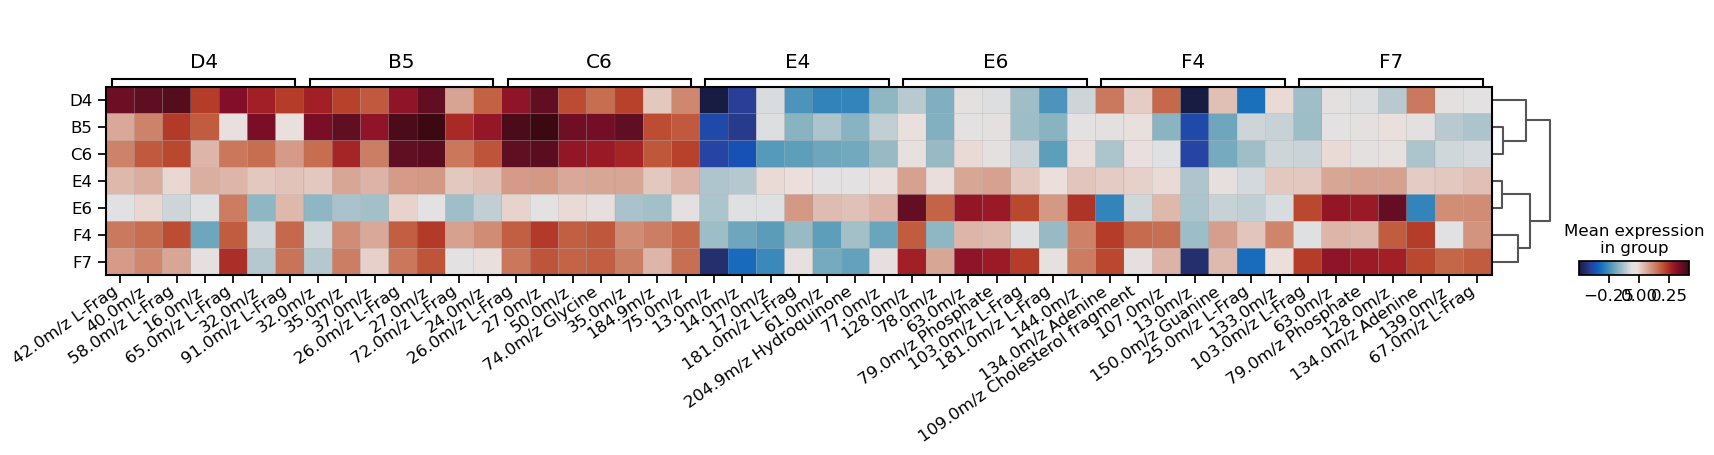

In [83]:
sc.tl.dendrogram(adata_subset, groupby='Core')
sc.tl.rank_genes_groups(adata_subset, groupby='Core', method='t-test_overestim_var')

with sns.plotting_context('notebook', font_scale=1.2):
    ax = sc.pl.rank_genes_groups_matrixplot(adata_subset, n_genes=7, use_raw=False, cmap=heatmap_cmp, show=False)
    xticklabels = ax['mainplot_ax'].get_xticklabels()
    ax['mainplot_ax'].set_xticklabels(xticklabels, rotation = 35, ha="right")
    ax['mainplot_ax'].tick_params(axis='x', pad=0)
    plt.show()

In [87]:
# Extract diff expression dataframe
dedf = sc.get.rank_genes_groups_df(adata_subset, group=None)

# Get top diff expression
topk=2
masses_largest = dedf.groupby('group').apply(lambda x: x.nlargest(topk,['scores'])).names.unique()
masses_lowest = dedf.groupby('group').apply(lambda x: x.nsmallest(topk,['scores'])).names.unique()
# masses = np.unique(np.concatenate([masses_largest, masses_lowest]))
masses = masses_largest

In [88]:
var = 'Core'

# Get subset of masses
adata_subset = adata_subset[:,masses]

# Get dataframe
df_SIMS = pd.DataFrame(adata_subset.X, columns=adata_subset.var_names)
df_SIMS[var] = adata_subset.obs[var].tolist()
# df_SIMS.drop(['1.0'], axis=1, inplace=True)

# Sort masses by GC eexpression
df_SIMS_var = (df_SIMS
                .melt(id_vars=var, var_name='mz', value_name='Normalized ion count'))
df = df_SIMS_var[df_SIMS_var[var] == 'F7'].groupby('mz').mean()
df.sort_values('Normalized ion count', inplace=True)
masses_sorted = df.index.tolist()

C:\Users\thu71\AppData\Local\Temp\ipykernel_35764\890832217.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df_SIMS_var[df_SIMS_var[var] == 'F7'].groupby('mz').mean()


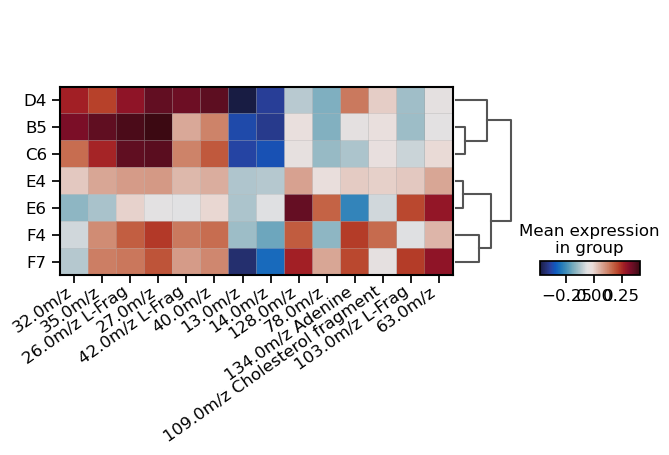

In [89]:
with sns.plotting_context('notebook', font_scale=1.2):
    ax = sc.pl.matrixplot(adata_subset, var_names=masses, groupby='Core',
                    cmap=heatmap_cmp, dendrogram=True, show=False)
    xticklabels = ax['mainplot_ax'].get_xticklabels()
    ax['mainplot_ax'].set_xticklabels(xticklabels, rotation = 35, ha="right")
    ax['mainplot_ax'].tick_params(axis='x', pad=0)
    plt.show()

C:\Users\thu71\AppData\Local\Temp\ipykernel_35764\1183181562.py:5: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_SIMS.iloc[:,:-1] = MinMaxScaler().fit_transform(df_SIMS.iloc[:,:-1].values)


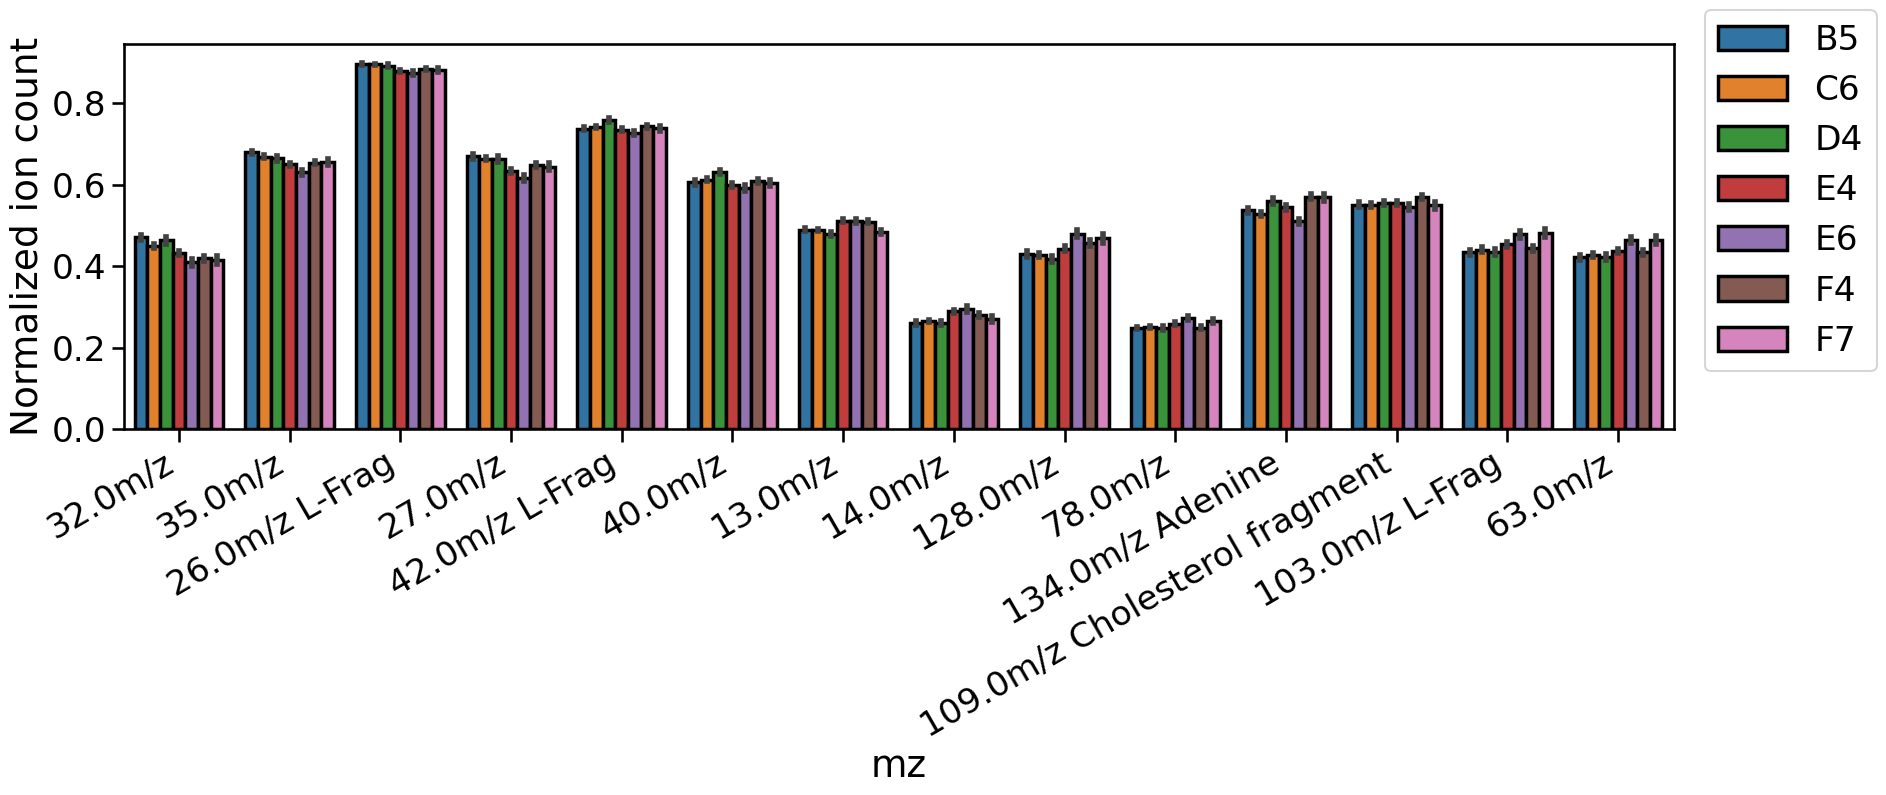

In [93]:
# Get dataframe
df_SIMS = pd.DataFrame(adata_subset.X, columns=adata_subset.var_names)
df_SIMS[var] = adata_subset.obs[var].tolist()
df_SIMS = df_SIMS[df_SIMS[var] != 'Other']
df_SIMS.iloc[:,:-1] = MinMaxScaler().fit_transform(df_SIMS.iloc[:,:-1].values)

# Sort masses by GC eexpression
df_SIMS_var = (df_SIMS
                .melt(id_vars=var, var_name='mz', value_name='Normalized ion count'))

# Plot
var = 'Core'
palette = adata_subset.uns[f'{var}_colors'][adata_subset.uns[f'dendrogram_{var}']['categories_idx_ordered']]

fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(data=df_SIMS_var, hue=var, x='mz', y='Normalized ion count', linewidth=2.5, edgecolor='k', ax=ax,)
plt.xticks(rotation = 30, ha='right')
plt.legend(bbox_to_anchor=(1.02, 0.15), loc='lower left', borderaxespad=0)
